In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Machine_Learning_Self

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Machine_Learning_Self


Loading DATA

In [ ]:


train_data = pd.read_csv("predictive-maintenance-dataset.csv")

ID_COl, LABEL_COL = ["ID", "vibration"]

train_data = train_data.dropna(subset = [LABEL_COL])
features = [col for col in train_data.columns if col != LABEL_COL and col != ID_COl]

label =  train_data[LABEL_COL].copy()
print(features)

['revolutions', 'humidity', 'x1', 'x2', 'x3', 'x4', 'x5']


Basic analysis

In [ ]:
train_data.head()

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5
0,1,93.744,73.999,18.0,167.743,19.745,1.266828,8787.937536,5475.852001
1,2,93.740,73.999,18.0,167.739,19.741,1.266774,8787.187600,5475.852001
2,3,93.736,73.998,18.0,167.734,19.738,1.266737,8786.437696,5475.704004
3,4,93.732,73.998,18.0,167.730,19.734,1.266683,8785.687824,5475.704004
4,5,93.729,73.998,18.0,167.727,19.731,1.266642,8785.125441,5475.704004


In [ ]:
train_data.shape

(109563, 9)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109563 entries, 0 to 112000
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           109563 non-null  int64  
 1   revolutions  109563 non-null  float64
 2   humidity     109563 non-null  float64
 3   vibration    109563 non-null  float64
 4   x1           109563 non-null  float64
 5   x2           109563 non-null  float64
 6   x3           109563 non-null  float64
 7   x4           109563 non-null  float64
 8   x5           109563 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 8.4 MB


In [ ]:
train_data.isnull().sum()

ID             0
revolutions    0
humidity       0
vibration      0
x1             0
x2             0
x3             0
x4             0
x5             0
dtype: int64

In [ ]:
train_data.drop(columns = "ID", axis = 1).describe().T
# .style.bar(subset = ['mean'], color = '#60f652').background_gradient(subset= ['std'], cmap = 'PuBu').background_gradient(subset= ['50%'], cmap = 'PuBu')

,count,mean,std,min,25%,50%,75%,max
revolutions,109563.0,46.250013,19.130226,16.933000,28.818000,43.295000,64.000000,93.744000
humidity,109563.0,74.216124,0.686551,72.399000,73.908000,74.207000,74.717000,75.400000
vibration,109563.0,28.340276,24.292500,2.000000,8.000000,21.280000,39.210000,100.000000
x1,109563.0,120.466137,19.068724,90.132000,103.054000,117.587000,138.124000,167.743000
x2,109563.0,-27.966111,19.216075,-56.353000,-45.418000,-31.471000,-10.007000,19.745000
x3,109563.0,0.623504,0.259938,0.231328,0.388194,0.580253,0.865416,1.266828
x4,109563.0,2505.025901,1884.049342,286.726489,830.477125,1874.457025,4096.000000,8787.937536
x5,109563.0,5508.504394,101.659813,5241.615201,5462.392464,5506.678849,5582.630089,5685.160000


In [ ]:
def hightlight_mean_greater(s):
  is_max = s > s.mean()
  return ['background-color: #606ff2'if i 
          else 'background-color: gray' for i in is_max]

In [ ]:
train_data.drop(columns= ["ID"]).head(20).style.apply(hightlight_mean_greater)

,revolutions,humidity,vibration,x1,x2,x3,x4,x5
0,93.744000,73.999000,18.000000,167.743000,19.745000,1.266828,8787.937536,5475.852001
1,93.740000,73.999000,18.000000,167.739000,19.741000,1.266774,8787.187600,5475.852001
2,93.736000,73.998000,18.000000,167.734000,19.738000,1.266737,8786.437696,5475.704004
3,93.732000,73.998000,18.000000,167.730000,19.734000,1.266683,8785.687824,5475.704004
4,93.729000,73.998000,18.000000,167.727000,19.731000,1.266642,8785.125441,5475.704004
5,93.725000,73.997000,18.010000,167.722000,19.728000,1.266605,8784.375625,5475.556009
6,93.721000,73.997000,18.010000,167.718000,19.724000,1.266551,8783.625841,5475.556009
7,93.717000,73.997000,18.010000,167.714000,19.720000,1.266497,8782.876089,5475.556009
8,93.713000,73.996000,18.010000,167.709000,19.717000,1.266460,8782.126369,5475.408016
9,93.709000,73.996000,18.010000,167.705000,19.713000,1.266406,8781.376681,5475.408016


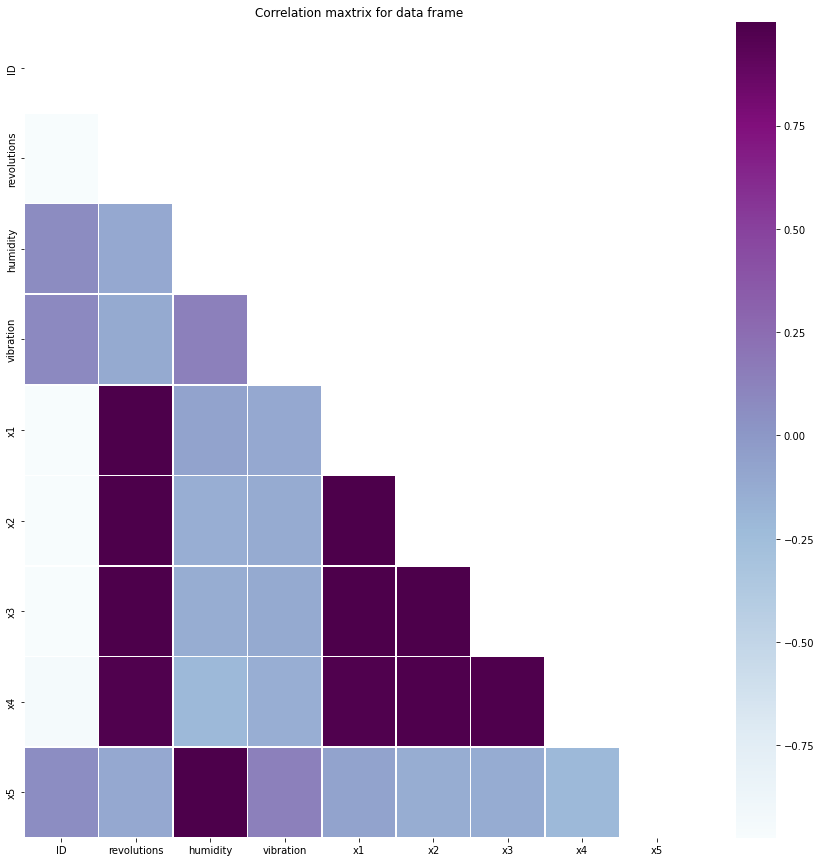

In [ ]:
corr = train_data.corr()
mask = np.triu(np.ones_like(corr,dtype = bool))

plt.figure(figsize = (15,15))
plt.title('Correlation maxtrix for data frame')
sns.heatmap(corr, mask = mask, cmap = "BuPu", linewidths = 0.5)
plt.show()

In [ ]:
train_data.drop(columns = "ID").corr()["vibration"].sort_values(ascending=False)

vibration      1.000000
x5             0.136830
humidity       0.136469
x1            -0.110225
revolutions   -0.114768
x3            -0.117370
x2            -0.119131
x4            -0.142570
Name: vibration, dtype: float64

Features analysis

In [ ]:
features

['revolutions', 'humidity', 'x1', 'x2', 'x3', 'x4', 'x5']

In [ ]:
train_data['n_missing'] = train_data[features].isna().sum()
train_data['std'] = train_data[features].std(axis = 1)
features += ['n_missing', 'std']
train_data

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5,n_missing,std
0,1,93.744,73.999,18.00,167.743,19.745,1.266828,8787.937536,5475.852001,NaN,3575.832760
1,2,93.740,73.999,18.00,167.739,19.741,1.266774,8787.187600,5475.852001,NaN,3575.599717
2,3,93.736,73.998,18.00,167.734,19.738,1.266737,8786.437696,5475.704004,NaN,3575.343408
3,4,93.732,73.998,18.00,167.730,19.734,1.266683,8785.687824,5475.704004,NaN,3575.110397
4,5,93.729,73.998,18.00,167.727,19.731,1.266642,8785.125441,5475.704004,NaN,3574.935650
...,...,...,...,...,...,...,...,...,...,...,...
111996,111997,20.186,73.992,2.00,94.178,-53.806,0.272813,407.474596,5474.816064,NaN,2040.631318
111997,111998,20.186,73.992,20.01,94.178,-53.806,0.272813,407.474596,5474.816064,NaN,2040.631318
111998,111999,20.185,73.992,20.01,94.177,-53.807,0.272800,407.434225,5474.816064,NaN,2040.633016
111999,112000,20.185,73.992,20.00,94.177,-53.807,0.272800,407.434225,5474.816064,NaN,2040.633016


In [ ]:
train_data[features] = train_data[features].fillna(train_data[features].mean())

In [ ]:
scaler = RobustScaler()
train_data[features] = scaler.fit_transform(train_data[features])

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [ ]:
train_data.head(10)

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5,n_missing,std
0,1,1.433943,-0.257108,18.00,1.430168,1.446330,1.438692,2.117113,-0.256383,NaN,4.777570
1,2,1.433830,-0.257108,18.00,1.430054,1.446217,1.438579,2.116883,-0.256383,NaN,4.776815
2,3,1.433716,-0.258344,18.00,1.429912,1.446133,1.438501,2.116654,-0.257614,NaN,4.775985
3,4,1.433602,-0.258344,18.00,1.429798,1.446020,1.438388,2.116424,-0.257614,NaN,4.775230
4,5,1.433517,-0.258344,18.00,1.429712,1.445935,1.438303,2.116252,-0.257614,NaN,4.774664
5,6,1.433403,-0.259580,18.01,1.429569,1.445850,1.438226,2.116022,-0.258844,NaN,4.773834
6,7,1.433290,-0.259580,18.01,1.429455,1.445737,1.438112,2.115793,-0.258844,NaN,4.773080
7,8,1.433176,-0.259580,18.01,1.429341,1.445624,1.437999,2.115563,-0.258844,NaN,4.772326
8,9,1.433062,-0.260816,18.01,1.429199,1.445540,1.437922,2.115333,-0.260075,NaN,4.771496
9,10,1.432949,-0.260816,18.01,1.429085,1.445427,1.437808,2.115104,-0.260075,NaN,4.770742


Modeling LGBMRegressor

In [ ]:
SEED = 2021
N_SPLIT = 5
VERBOSE = 1000
N_ESTIMATORS = 20000
EARLY_STOPPING_ROUND = 200

def metric(y, y_predict):
  return mean_absolute_error(y, y_predict)

lgb_params = {
    'objective': 'mae',
    'n_estimators': N_ESTIMATORS,
    'random-state': SEED,
    'learning-rate': 5e-3,
    'subsameple': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lamda': 1e-1,
    'min_child_weight': 256,
    'min_child_sample': 20
}

In [ ]:
lgb_oof = np.zeros(train_data.shape[0])
lgb_importances = pd.DataFrame()
train_data.shape

(109563, 11)

In [ ]:
for fold, (train_index, val_index) in enumerate(KFold(n_splits = N_SPLIT, shuffle = True, random_state=SEED).split(X = train_data, y = label)):
  print(f"==== Fold {fold} ====")

  X_train, y_train = train_data[features].iloc[train_index], label.iloc[train_index]
  X_valid, y_valid = train_data[features].iloc[val_index], label.iloc[val_index]
  
  model = lgb.LGBMRegressor(**lgb_params)
  model.fit(
      X_train, y_train,
      eval_set = [(X_valid, y_valid)],
      eval_metric = 'mae',
      early_stopping_rounds = EARLY_STOPPING_ROUND,
      verbose = VERBOSE
  )
  lgb_oof[val_index] = model.predict(X_valid)

  score = metric(y_valid,  lgb_oof[val_index])

  print(f"Fold {fold} - lgb score: {score: .6f}\n")

print(f"00F lgb score: {metric(label, lgb_oof)}")


==== Fold 0 ====
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 8.6498
[2000]	valid_0's l1: 8.61296
[3000]	valid_0's l1: 8.60318
Early stopping, best iteration is:
[2923]	valid_0's l1: 8.60115
Fold 0 - lgb score:  8.601152

==== Fold 1 ====
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 8.82592
[2000]	valid_0's l1: 8.80323
[3000]	valid_0's l1: 8.79528
[4000]	valid_0's l1: 8.78439
[5000]	valid_0's l1: 8.77838
[6000]	valid_0's l1: 8.76061
[7000]	valid_0's l1: 8.75223
Early stopping, best iteration is:
[7734]	valid_0's l1: 8.74954
Fold 1 - lgb score:  8.749538

==== Fold 2 ====
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 8.69142
[2000]	valid_0's l1: 8.66389
[3000]	valid_0's l1: 8.64724
[4000]	valid_0's l1: 8.63771
[5000]	valid_0's l1: 8.62543
[6000]	valid_0's l1: 8.61411
[7000]	valid_0's l1: 8.60768
[8000]	valid_0's l1: 8.60295
Early stopping, best iteration is:
[8502]	valid_0

In [ ]:
Train = train_data[features] 

In [ ]:
train_data

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5,n_missing,std,vibration_pre
0,1,1.433943,-0.257108,18.00,1.430168,1.446330,1.438692,2.117113,-0.256383,NaN,4.777570,18.003308
1,2,1.433830,-0.257108,18.00,1.430054,1.446217,1.438579,2.116883,-0.256383,NaN,4.776815,18.013982
2,3,1.433716,-0.258344,18.00,1.429912,1.446133,1.438501,2.116654,-0.257614,NaN,4.775985,18.014813
3,4,1.433602,-0.258344,18.00,1.429798,1.446020,1.438388,2.116424,-0.257614,NaN,4.775230,18.014813
4,5,1.433517,-0.258344,18.00,1.429712,1.445935,1.438303,2.116252,-0.257614,NaN,4.774664,18.026647
...,...,...,...,...,...,...,...,...,...,...,...,...
111996,111997,-0.656842,-0.265760,2.00,-0.667494,-0.630736,-0.644228,-0.449234,-0.264998,NaN,-0.194031,20.473126
111997,111998,-0.656842,-0.265760,20.01,-0.667494,-0.630736,-0.644228,-0.449234,-0.264998,NaN,-0.194031,20.473126
111998,111999,-0.656870,-0.265760,20.01,-0.667522,-0.630764,-0.644256,-0.449246,-0.264998,NaN,-0.194026,24.545436
111999,112000,-0.656870,-0.265760,20.00,-0.667522,-0.630764,-0.644256,-0.449246,-0.264998,NaN,-0.194026,21.910783


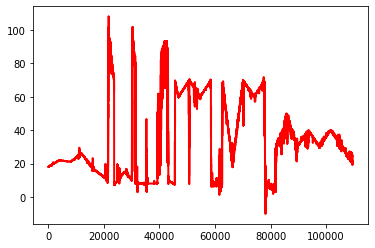

In [ ]:
vibration = train_data['vibration']
vibration_pre = train_data['vibration_pre']
vibration_array = np.array(vibration)
vibration_pre_array = np.array(vibration_pre)
plt.plot(vibration_pre_array,color="red",lw=2)

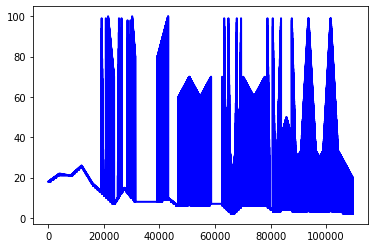

In [ ]:
plt.plot(vibration_array,color="blue",lw=2)

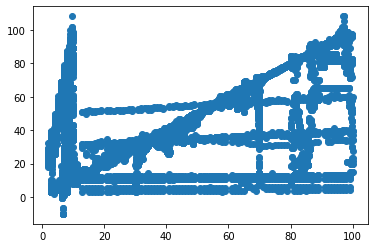

In [ ]:
plt.scatter(vibration_array,vibration_pre_array)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_train,X_val, y_train, y_val = train_test_split(Train,Test,test_size = 0.2,random_state=42)

In [ ]:
X_val

,revolutions,humidity,x1,x2,x3,x4,x5,n_missing,std
99312,-0.615912,-0.584672,-0.633790,-0.582785,-0.601304,-0.430796,-0.581982,NaN,-0.248239
95655,-0.609999,-0.326329,-0.621899,-0.582813,-0.597146,-0.428027,-0.325286,NaN,-0.211721
13235,0.585214,-0.739184,0.567608,0.614103,0.602718,0.675760,-0.735161,NaN,0.725091
6059,0.938719,-2.053152,0.891930,0.995340,0.988603,1.209741,-2.027292,NaN,1.879747
35291,0.609431,0.404203,0.618278,0.612041,0.604102,0.709318,0.404518,NaN,0.920413
...,...,...,...,...,...,...,...,...,...
29156,0.541669,0.872682,0.561106,0.534015,0.528209,0.616537,0.875589,NaN,0.794847
19868,0.565573,-0.363412,0.556573,0.586004,0.575648,0.648870,-0.362177,NaN,0.713867
100914,-0.645273,-0.768850,-0.667494,-0.607749,-0.629476,-0.444151,-0.764541,NaN,-0.269491
42479,0.326730,1.008653,0.348617,0.317359,0.314438,0.345270,1.012759,NaN,0.375370
